In [1]:
import pandas as pd

# COVID-19

In [2]:
# Read

In [3]:
data = pd.read_csv('output_data/latest.csv')
data.Region= data.Region.str.replace('CIUDAD DE MEXICO','CDMX',regex=True) #smh
data.Region= data.Region.str.replace('DISTRITO FEDERAL','CDMX',regex=True)

In [4]:
#To use symptoms as indicator, uncomment the next two lines:
#data = data.drop(['Date_Confirmed'], axis=1)
#data = data.rename(columns={'Date_Symptoms':'Date_Confirmed'}) # Rename index

In [5]:
# Totals and delta

In [6]:
    # Region delta (ie, new cases)
cum_df = (data.groupby(['Region','Date_Confirmed'])['Date_Confirmed'].count()).to_frame()

In [7]:
    # Rename because duplicate index
cum_df['Region_Delta'] = cum_df['Date_Confirmed']

In [8]:
    # Region cumulative by date
cum_df['Region_Cumulative'] = cum_df.groupby(['Region'])['Region_Delta'].cumsum()

In [9]:
    # Clean up
cum_df = cum_df.drop(['Date_Confirmed'], axis=1)

In [10]:
# To view full table:
# from IPython.core.display import HTML
# display(HTML(cum_df.to_html()))

# Tables

In [11]:
# Read

In [12]:
pivot_tbl_cum = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.reset_index()
pivot_tbl_daily = cum_df.reset_index().pivot('Region','Date_Confirmed','Region_Delta').T.reset_index()

In [13]:
# Save

In [14]:
pivot_tbl_cum.to_csv('output_data/time_series/total-mexico-covid19.csv', index=False)
pivot_tbl_daily.fillna(0).to_csv('output_data/time_series/daily-mexico-covid19.csv', index=False)

In [15]:
# Set datetime

In [16]:
pivot_tbl_cum['Date_Confirmed'] = pd.to_datetime(pivot_tbl_cum.Date_Confirmed, format='%d-%m-%Y')
pivot_tbl_cum['Date_Confirmed'] = pivot_tbl_cum['Date_Confirmed'].dt.strftime('%d-%m-%Y')

In [17]:
# Set datetime

In [18]:
pivot_tbl_daily['Date_Confirmed'] = pd.to_datetime(pivot_tbl_daily.Date_Confirmed, format='%d-%m-%Y')
pivot_tbl_daily['Date_Confirmed'] = pivot_tbl_daily['Date_Confirmed'].dt.strftime('%d-%m-%Y')

In [19]:
# Set index

In [20]:
pivot_tbl_cum = pivot_tbl_cum.set_index(pd.DatetimeIndex(pivot_tbl_cum['Date_Confirmed']))
pivot_tbl_daily = pivot_tbl_daily.set_index(pd.DatetimeIndex(pivot_tbl_daily['Date_Confirmed']))

# Plots

In [21]:
from numpy import *
import math
import matplotlib.pyplot as plt

### Confirmed cases

#### Cumulative
Note exponential growth is expected and not really informative.

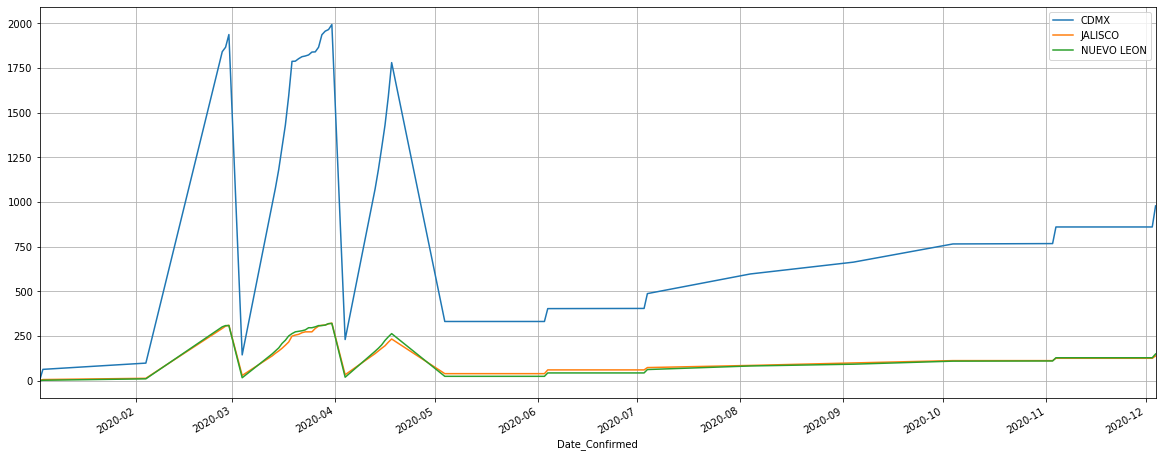

In [23]:
plt.figure(figsize=(20,8))

for state in ['CDMX', 'JALISCO', 'NUEVO LEON']:
    pivot_tbl_daily[state].fillna(0).cumsum().plot()

plt.legend()
plt.grid(True)
plt.show()

#### Growth rate (log scale)
**Notice there are no dates:** all we care is about the growth rate (so each region starts at day 0 from first case).

In [24]:
len(pivot_tbl_daily)

45

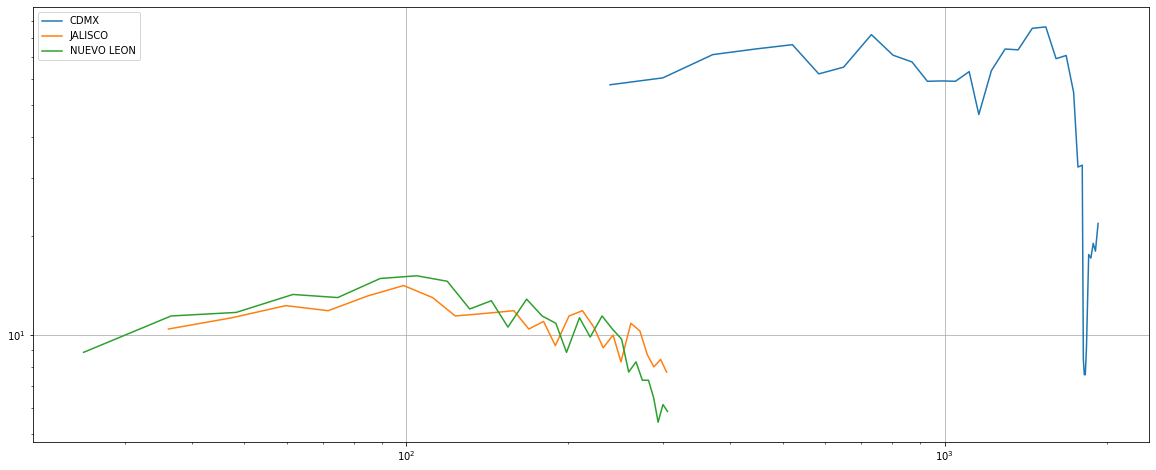

In [25]:
plt.figure(figsize=(20,8))

for state in ['CDMX', 'JALISCO', 'NUEVO LEON']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label=state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()

#### Cumulative
Note exponential growth is expected and not really informative.

In [27]:
# Need fix

# Starting at date w/certain number of cases
def select_min_cases(df, min):
    df2_state = []
    df2_date= []
    df2_cases= []
    for state in df.columns:
        #print(df.columns)
        for index in range(len(df[state])):
            if df[state][index] >= min:
                #print(state)
                #print(df[state].index[index])
                #print((df[state][index]))
                df2_state.append(state)
                df2_date.append(df[state].index[index])
                df2_cases.append(df[state][index])
            #if df[state][index] < num:
                #print(None)
    my_df = pd.DataFrame({'Region': pd.Series(df2_state), 'Date_Confirmed': pd.Series(df2_date), 'Region_Cumulative': pd.Series(df2_cases)})
    #my_df = my_df.set_index(['Region','Date_Confirmed'])
    return my_df

min_cases = select_min_cases(pivot_tbl_cum, 15).reset_index()
min_cases = min_cases.drop(['index'], axis=1).reset_index()
min_cases = min_cases.reset_index().pivot('Region','Date_Confirmed','Region_Cumulative').T.sort_index()
min_cases = min_cases.fillna(method='ffill')
daily_min_cases = min_cases.diff()

plt.figure(figsize=(20,8))

for state in ['CDMX', 'JALISCO', 'NUEVO LEON']:
    daily_min_cases[state].fillna(0).rolling(window=7).mean().plot()
    
plt.legend()
plt.grid(True)
plt.show()

#### Growth rate (log scale)
**Notice there are no dates:** all we care is about the growth rate (so each region starts at day 0 from first case).

In [30]:
pivot_tbl_cum.keys()

Index(['Date_Confirmed', 'AGUASCALIENTES', 'BAJA CALIFORNIA',
       'BAJA CALIFORNIA\nSUR', 'BAJA CALIFORNIA SUR', 'CAMPECHE', 'CDMX',
       'CHIAPAS', 'CHIHUAHUA', 'COAHUILA', 'COLIMA', 'DURANGO', 'GUANAJUATO',
       'GUERRERO', 'HIDALGO', 'JALISCO', 'MEXICO', 'MICHOACAN', 'MORELOS',
       'NAYARIT', 'NUEVO LEON', 'OAXACA', 'PUEBLA', 'QUERETARO',
       'QUINTANA ROO', 'SAN LUIS POTOSI', 'SINALOA', 'SONORA', 'TABASCO',
       'TAMAULIPAS', 'TLAXCALA', 'VERACRUZ', 'YUCATAN', 'ZACATECAS'],
      dtype='object', name='Region')

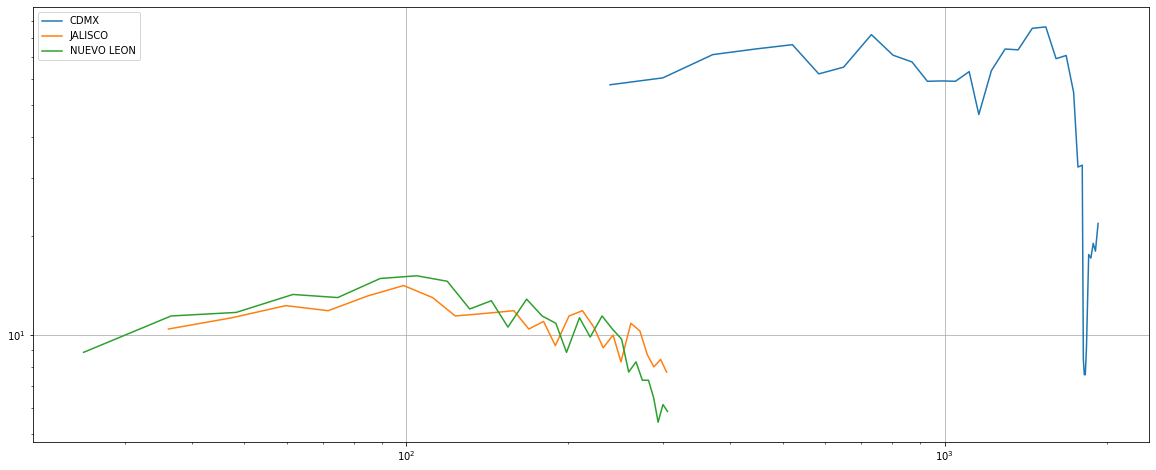

In [31]:
plt.figure(figsize=(20,8))

for state in ['CDMX', 'JALISCO', 'NUEVO LEON']:
    plt.plot(list(pivot_tbl_cum[state].dropna().rolling(window=7).mean()), list(pivot_tbl_daily[state].dropna().rolling(window=7).mean()), label = state)

plt.legend()
plt.grid(True)

plt.yscale('log')
plt.xscale('log')

plt.show()